# Predicting Lending Decisions: Analysis of the LendingClub Dataset V part

In this part of the analysis the machine learning models will be trained in order to predict the interest rate, that is, a numerical variable.

### Importing libraries for the V part

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib, seaborn and yellowbrick will be used for data visualization. Scipy, Statsmodels, Researchpy, Math, Random will be used for conducting statistical tests, calculating confidence intervals. Sklearn will be used for spliting data into training and testing samples, building and testing machine learning models.

In [3]:
import numpy as np 
import pandas as pd
import sqlite3
import duckdb
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from scipy import stats
from scipy.stats import chi2_contingency, norm 
import researchpy as rp

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import optuna

import sklearn
import sklearn.ensemble
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, \
 precision_score, recall_score, confusion_matrix, mean_absolute_error,\
mean_squared_error,mean_squared_log_error,r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier

from imblearn.pipeline import make_pipeline, Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from yellowbrick.classifier import confusion_matrix, ClassificationReport

import joblib
import shap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from lending_utils import *

## IV. PREDICTING AN INTEREST RATE

### Importing the data

For this part only the dataset 'accepted.csv' will be needed for the analysis. This dataset is imported and saved into pandas dataframe.

In [4]:
accepted = pd.read_csv("data/accepted.csv")


### Preparing the data for the further analysis

The data will be prepared with the same steps as in the I part.

It can be seen that the dataframe "accepted", beginning from the row index 2260699, includes rows with missing data. These rows are removed from the dataframe.

Also, geographical and personal data would certainly not be used for the analysis, thus, these columns were removed from the dataframes.

In [5]:
accepted_mod = accepted.loc[:2260698, :]

In [6]:
accepted_mod = accepted_mod.drop(columns=["id", 'member_id', 'url', 'zip_code', 'addr_state'])


#### Initial feature selection

The initial list of features is selected based on the descriptions of these features in the data dictionary https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv?select=LCDataDictionary.xlsx. The selection of the features is not well-justified, as the time to understand the financial data for this project is limited. Also, features such as emp_length, risk_score are prepared as in the same way as in the part I.

The same features are selected as in the III part.

In [7]:
intrate_prediction = accepted_mod[["int_rate","loan_amnt", "loan_status",
                                 "emp_length",
                                 "delinq_2yrs", 
                             'fico_range_low','fico_range_high',
                                 'annual_inc',
                             'inq_last_6mths','pub_rec',
                             'revol_util',
                                 'home_ownership',
                                 'purpose',
                            'total_acc','initial_list_status',
                             'dti','acc_now_delinq',
                            'tot_cur_bal','il_util','all_util',
                             'inq_fi','inq_last_12m','chargeoff_within_12_mths',
                            'delinq_amnt','mths_since_last_major_derog',
                            'mths_since_last_record','mths_since_recent_bc_dlq',
                            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
                            'pct_tl_nvr_dlq','pub_rec_bankruptcies','tot_hi_cred_lim',
                             'total_bc_limit','total_il_high_credit_limit',
                            'verification_status']]

In [8]:
intrate_prediction_mod = duckdb.sql("""SELECT
                     int_rate,
                     loan_amnt AS loan_amount,
                      CASE
                      WHEN emp_length = '< 1 year' THEN 0
                      WHEN emp_length = '1 year' THEN 1
                      WHEN emp_length = '2 years' THEN 2
                      WHEN emp_length = '3 years' THEN 3
                      WHEN emp_length = '4 years' THEN 4
                      WHEN emp_length = '5 years' THEN 5
                      WHEN emp_length = '6 years' THEN 6
                      WHEN emp_length = '7 years' THEN 7
                      WHEN emp_length = '8 years' THEN 8
                      WHEN emp_length = '9 years' THEN 9
                      ELSE 10 END AS emp_length,
                     annual_inc, loan_status, delinq_2yrs,
                         (fico_range_low + fico_range_high)/2 AS risk_score,
                             inq_last_6mths,pub_rec,
                             revol_util,
                            total_acc,initial_list_status,
                             dti,acc_now_delinq,
                            tot_cur_bal,il_util,all_util,
                                 home_ownership,
                                 purpose,
                             inq_fi,inq_last_12m,chargeoff_within_12_mths,
                            delinq_amnt,mths_since_last_major_derog,
                            mths_since_last_record,mths_since_recent_bc_dlq,
                            mths_since_recent_inq, mths_since_recent_revol_delinq,
                            pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,
                             total_bc_limit,total_il_high_credit_limit,
                            verification_status
                      FROM intrate_prediction
                            """).df()
pd.set_option('display.max_columns', 500)
intrate_prediction_mod.head()

,int_rate,loan_amount,emp_length,annual_inc,loan_status,delinq_2yrs,risk_score,inq_last_6mths,pub_rec,revol_util,total_acc,initial_list_status,dti,acc_now_delinq,tot_cur_bal,il_util,all_util,home_ownership,purpose,inq_fi,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,verification_status
0,13.99,3600.0,10,55000.0,Fully Paid,0.0,677.0,1.0,0.0,29.7,13.0,w,5.91,0.0,144904.0,36.0,34.0,MORTGAGE,debt_consolidation,3.0,4.0,0.0,0.0,30.0,NaN,69.0,4.0,69.0,76.9,0.0,178050.0,2400.0,13734.0,Not Verified
1,11.99,24700.0,10,65000.0,Fully Paid,1.0,717.0,4.0,0.0,19.2,38.0,w,16.06,0.0,204396.0,73.0,29.0,MORTGAGE,small_business,0.0,6.0,0.0,0.0,NaN,NaN,NaN,0.0,6.0,97.4,0.0,314017.0,79300.0,24667.0,Not Verified
2,10.78,20000.0,10,63000.0,Fully Paid,0.0,697.0,0.0,0.0,56.2,18.0,w,10.78,0.0,189699.0,73.0,65.0,MORTGAGE,home_improvement,2.0,1.0,0.0,0.0,NaN,NaN,NaN,10.0,NaN,100.0,0.0,218418.0,6200.0,14877.0,Not Verified
3,14.85,35000.0,10,110000.0,Current,0.0,787.0,0.0,0.0,11.6,17.0,w,17.06,0.0,301500.0,70.0,45.0,MORTGAGE,debt_consolidation,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,381215.0,62500.0,18000.0,Source Verified
4,22.45,10400.0,3,104433.0,Fully Paid,1.0,697.0,3.0,0.0,64.5,35.0,w,25.37,0.0,331730.0,84.0,78.0,MORTGAGE,major_purchase,2.0,3.0,0.0,0.0,NaN,NaN,12.0,1.0,12.0,96.6,0.0,439570.0,20300.0,88097.0,Source Verified


As categorical and numerical feature variables were examined in the III part, in this part the exploratory analysis of these variables will not be presented. 

#### 'Interest rate' as a target variable

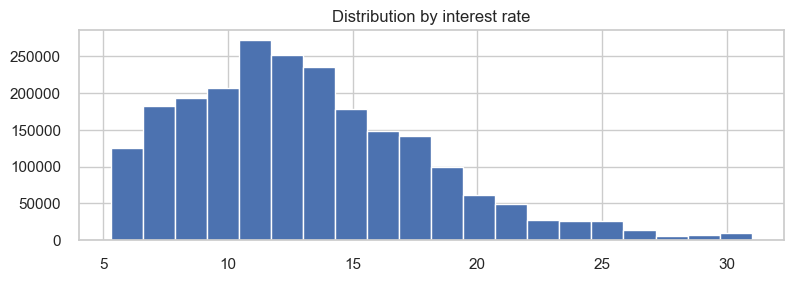

In [9]:
plt.figure(figsize=[20,6])
 
plt.subplot(221)
plt.hist(intrate_prediction_mod['int_rate'],bins=20,color='b')

plt.title('Distribution by interest rate');


#### Categorical variables

See the III part.

In [10]:
intrate_prediction_describe = intrate_prediction_mod.describe()

In [11]:
intrate_prediction_cat = intrate_prediction_mod.copy()
for i in range(len(intrate_prediction_describe.columns)):
    intrate_prediction_cat =  intrate_prediction_cat.drop(columns = [intrate_prediction_describe.columns[i]])                                   
   

In [12]:
intrate_prediction_cat.head()

,loan_status,initial_list_status,home_ownership,purpose,verification_status
0,Fully Paid,w,MORTGAGE,debt_consolidation,Not Verified
1,Fully Paid,w,MORTGAGE,small_business,Not Verified
2,Fully Paid,w,MORTGAGE,home_improvement,Not Verified
3,Current,w,MORTGAGE,debt_consolidation,Source Verified
4,Fully Paid,w,MORTGAGE,major_purchase,Source Verified


### Examining relationships between numeric variables

The following function present correlation coeficients between numerical feature variables and the target variable 'interest_rate'. The coefficients are not high, thus, the use of these variables for training of predictive models will have a limited success (some identified relationships are presented at the end of the file).

In [105]:
intrate_prediction_mod.corrwith(intrate_prediction_mod["int_rate"])

int_rate                          1.000000
loan_amount                       0.098082
emp_length                       -0.007643
annual_inc                       -0.050583
delinq_2yrs                       0.058909
risk_score                       -0.415993
inq_last_6mths                    0.188399
pub_rec                           0.053381
revol_util                        0.262670
total_acc                        -0.040951
dti                               0.124491
acc_now_delinq                    0.015562
tot_cur_bal                      -0.085616
il_util                           0.144010
all_util                          0.289967
inq_fi                            0.136142
inq_last_12m                      0.166029
chargeoff_within_12_mths          0.014187
delinq_amnt                       0.004939
mths_since_last_major_derog      -0.032136
mths_since_last_record           -0.010175
mths_since_recent_bc_dlq         -0.018169
mths_since_recent_inq            -0.145741
mths_since_

#### Checking for missing values

See the III part. 

#### Cleaning the data

Data are cleaned in the same ways as in the III part. 

Rows with missing values for some of variables were removed. It was supposed that it would not negativelly affect the analysis as there are still a lot of data left.

In [14]:
intrate_prediction_mod1 = intrate_prediction_mod.dropna(subset=['int_rate','dti','revol_util','pub_rec_bankruptcies',
                                                                'chargeoff_within_12_mths','inq_last_6mths'])
intrate_prediction_mod1.isnull().sum() 

int_rate                                0
loan_amount                             0
emp_length                              0
annual_inc                              0
loan_status                             0
delinq_2yrs                             0
risk_score                              0
inq_last_6mths                          0
pub_rec                                 0
revol_util                              0
total_acc                               0
initial_list_status                     0
dti                                     0
acc_now_delinq                          0
tot_cur_bal                         68817
il_util                           1066175
all_util                           864299
home_ownership                          0
purpose                                 0
inq_fi                             864299
inq_last_12m                       864299
chargeoff_within_12_mths                0
delinq_amnt                             0
mths_since_last_major_derog       

##### Dropping rows with certain values

Rows with small numbers of values for some of the variables were dropped from the dataset in order to avoid the data not being present in either training or test datasets. 

In [15]:
intrate_prediction_mod2 = intrate_prediction_mod1[(intrate_prediction_mod1["loan_status"] != "Default") & \
    (intrate_prediction_mod1["loan_status"] != "Does not meet the credit policy. Status:Charged Off") & \
     (intrate_prediction_mod1["loan_status"] != "Does not meet the credit policy. Status:Fully Paid") &\
     (intrate_prediction_mod1["loan_status"] != "Late (31-120 days)") &\
     (intrate_prediction_mod1["loan_status"] != "Late (16-30 days)")]


In [16]:
intrate_prediction_mod2 = intrate_prediction_mod2[(intrate_prediction_mod2["purpose"] != "wedding") & \
    (intrate_prediction_mod2["purpose"] != "educational") & \
     (intrate_prediction_mod2["purpose"] != "renewable_energy") &\
    (intrate_prediction_mod2["purpose"] != "house")]

In [17]:
intrate_prediction_mod2 = intrate_prediction_mod2[(intrate_prediction_mod2["home_ownership"] != "ANY") & \
    (intrate_prediction_mod2["home_ownership"] != "NONE") & \
     (intrate_prediction_mod2["home_ownership"] != "OTHER")]

In [18]:
intrate_prediction_mod2.value_counts("loan_status")

loan_status
Fully Paid         1066205
Current             868460
Charged Off         265964
In Grace Period       8351
dtype: int64

##### Dropping rows with values which are out of scales

Rows with values which do not fit into scale for such variable as 'dti' were also removed.

In [19]:
intrate_prediction_mod2 = intrate_prediction_mod2[(intrate_prediction_mod2.dti <= 100)&(intrate_prediction_mod2.dti > 0)]

##### Dropping certain variables

After the correlation analysis one of two highly correlated features (such as 'tol_cur_bal' and 'tot_hi_cred_lim' and 'mths_since_recent_bc_dlq' and 'mths_since_recent_revol_delinq') was removed from the data set. Also, some features which are not well undestood or were supposed to characterize companies and not individuals or having highly skewed distributions were also removed from the list of features. 

In [20]:
intrate_prediction_mod3 = intrate_prediction_mod2.drop(columns = ['tot_hi_cred_lim', 
                                                                'mths_since_recent_bc_dlq', 
                                                                'mths_since_last_major_derog',
                                                                'mths_since_last_record',
                                                               'mths_since_recent_inq',
                                                                'tot_cur_bal',
                                                                'mths_since_recent_revol_delinq',
                                                               'il_util', 'all_util',
                                                                'inq_fi','inq_last_12m',
                                                               'pct_tl_nvr_dlq','total_bc_limit',
                                                                'total_il_high_credit_limit'])

### Machine learning

#### Randomly selecting the data for machine learning

For machine learning purposes the the random sample of 30000 rows was selected.

In [21]:
intrate_prediction_sample = intrate_prediction_mod3.sample(n=30000)
intrate_prediction_sample.head()

,int_rate,loan_amount,emp_length,annual_inc,loan_status,delinq_2yrs,risk_score,inq_last_6mths,pub_rec,revol_util,total_acc,initial_list_status,dti,acc_now_delinq,home_ownership,purpose,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,verification_status
928279,9.44,7000.0,3,130000.0,Current,0.0,682.0,0.0,0.0,32.6,8.0,w,4.57,0.0,OWN,home_improvement,0.0,0.0,0.0,Not Verified
1573830,12.61,3200.0,10,48000.0,Current,0.0,707.0,0.0,0.0,48.0,11.0,f,16.25,0.0,MORTGAGE,other,0.0,0.0,0.0,Source Verified
1560561,23.87,10800.0,10,60000.0,In Grace Period,2.0,662.0,1.0,0.0,57.2,12.0,f,15.50,0.0,RENT,other,0.0,0.0,0.0,Verified
1921407,13.99,16000.0,10,180000.0,Fully Paid,0.0,732.0,2.0,0.0,72.2,45.0,f,10.27,0.0,MORTGAGE,debt_consolidation,0.0,0.0,0.0,Verified
750114,23.40,13100.0,0,74000.0,Current,0.0,687.0,1.0,0.0,53.9,6.0,f,18.52,0.0,RENT,credit_card,0.0,0.0,0.0,Source Verified


#### Spliting the data into training and test datasets

First, the data were split into feature variables and target variable as well as into training and testing datasets. 

70 percent of data were included into the training dataset, 30 percent into the testing dataset. The training data set was split into  half (for training and validation).

In [22]:
X = intrate_prediction_sample.drop(['int_rate'],axis=1)
y = intrate_prediction_sample['int_rate']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=123)


#### Building a machine learning pipeline

Next, pipelines of transforming data were constructed. As for some categorical variables it was needed to encode them into numbers, one hot encoder function was applied. For numerical variables, standart scaler was applied to transform the variables into comparable scales.

In [24]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore')),
])


In [25]:
intrate_prediction_mod3_describe = intrate_prediction_mod3.describe()
print(intrate_prediction_mod3_describe.columns)
intrate_prediction_cat = intrate_prediction_mod3.copy()
for i in range(len(intrate_prediction_mod3_describe.columns)):
    intrate_prediction_cat =  intrate_prediction_cat.drop\
    (columns = [intrate_prediction_mod3_describe.columns[i]])
print(intrate_prediction_cat.columns)

Index(['int_rate', 'loan_amount', 'emp_length', 'annual_inc', 'delinq_2yrs',
       'risk_score', 'inq_last_6mths', 'pub_rec', 'revol_util', 'total_acc',
       'dti', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies'],
      dtype='object')
Index(['loan_status', 'initial_list_status', 'home_ownership', 'purpose',
       'verification_status'],
      dtype='object')


In [26]:
numeric_features = ['loan_amount', 'emp_length', 'annual_inc', 'delinq_2yrs',
       'risk_score', 'inq_last_6mths', 'pub_rec', 'revol_util', 'total_acc',
       'dti', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies']
categorical_features = ['loan_status', 'initial_list_status', 'verification_status', 'home_ownership',
                                 'purpose']


In [27]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
]) 

As the target variable is numerical, various regressors are used for machine learning. 

In [28]:
regressors = [
    LinearRegression()
    ,DecisionTreeRegressor()
    ,RandomForestRegressor()
    ,GradientBoostingRegressor()
    ,SVR()
    ,KNeighborsRegressor()
    ,Lasso()
    ,Ridge()
    ,ElasticNet()
    ,xgb.XGBRegressor()
]


A function for running regression pipelines, cross-validation, calculating matrics, printing and saving outputs was created.

In [57]:
def score_regression_model(x_train, y_train, x_val, y_val, estimator, df, models_list, **kwargs):
    
    # Fitting model and prediction:
    pipeline = Pipeline(steps = [
                   ('preprocessor', preprocessor),
                   ('regressor',regressor)
    ])
    model = pipeline.fit(x_train, y_train)
    prediction = model.predict(x_val)
    
    # Cross_validation:
    cross_test = cross_validate(pipeline, x_train, y_train, cv=5,
                                scoring=("neg_mean_absolute_error", "neg_mean_squared_error","r2"))
    
    # Metrics:
    mae = sum(list(cross_test.values())[2])/len(list(cross_test.values())[2])
    mse = sum(list(cross_test.values())[3])/len(list(cross_test.values())[3])
    r2s = sum(list(cross_test.values())[4])/len(list(cross_test.values())[4])
    rmse = np.sqrt(abs(mse))
    
    #Prints:
    print (estimator.__class__.__name__)
    print (f'Cross-validation')
    print ("MAEs: {}".format(list(cross_test.values())[2]))
    print ("MSEs: {}".format(list(cross_test.values())[3]))
    print ("R2_scores: {}".format(list(cross_test.values())[4]))
    print("MAE (average): {}".format(abs(mae)))
    print("MSE (average): {}".format(abs(mse)))
    print("RMSE (average): {}".format(rmse))
    print("R2_score (average): {}".format(abs(r2s)))
    print('')
    
    # Appends:
    cross_vals.append(cross_test)
    models_list.append(model)
    predictions.append(prediction)
    df["model_name"].append(f'{estimator.__class__.__name__}')
    df["mae"].append(abs(mae).round(3))
    df["mse"].append(abs(mse).round(3))
    df["rmse"].append(rmse.round(3))
    df["r2_score"].append(abs(r2s).round(3))

#### Running the machine learning pipeline

The function was run on each of regressors in the regressors' list.

In [58]:
cross_vals = []
models = []
predictions = []
scores = {}
scores["mae"] = []
scores["mse"] = []
scores["model_name"] = []
scores["rmse"] = []
scores["r2_score"] = []
for regressor in regressors:
    score_regression_model(X_train, y_train, X_val, y_val, regressor, scores, models)

LinearRegression
Cross-validation
MAEs: [-3.10452634 -3.11741384 -2.96056786 -2.96943571 -3.02156756]
MSEs: [-16.65354088 -16.90716063 -14.50819252 -15.15062484 -15.46295677]
R2_scores: [0.32261923 0.31381463 0.33160218 0.32459231 0.3188522 ]
MAE (average): 3.0347022619047617
MSE (average): 15.736495125953308
RMSE (average): 3.966925147510765
R2_score (average): 0.3222961105084625

DecisionTreeRegressor
Cross-validation
MAEs: [-4.55386667 -4.32845238 -4.32079524 -4.16965238 -4.32423333]
MSEs: [-36.26661286 -32.68763462 -31.79710157 -30.39565671 -32.60933119]
R2_scores: [-0.47514012 -0.32664361 -0.46490428 -0.35502399 -0.43645064]
MAE (average): 4.3393999999999995
MSE (average): 32.75126739047619
RMSE (average): 5.722872302478554
R2_score (average): 0.4116325295586073

RandomForestRegressor
Cross-validation
MAEs: [-3.1404621  -3.13214586 -2.97417857 -2.99584333 -2.98520257]
MSEs: [-17.02651677 -17.15011057 -14.7321866  -15.29466107 -15.1784629 ]
R2_scores: [0.30744848 0.30395439 0.32128

In [59]:
scores = pd.DataFrame(scores)
scores = scores.set_index('model_name')
scores

,mae,mse,rmse,r2_score
model_name,,,,
LinearRegression,3.035,15.736,3.967,0.322
DecisionTreeRegressor,4.339,32.751,5.723,0.412
RandomForestRegressor,3.046,15.876,3.985,0.316
GradientBoostingRegressor,2.956,15.115,3.888,0.349
SVR,2.926,15.426,3.928,0.336
KNeighborsRegressor,3.267,18.542,4.306,0.201
Lasso,3.498,20.198,4.494,0.130
Ridge,3.012,15.524,3.940,0.332
ElasticNet,3.420,19.433,4.408,0.163


In [60]:
for model in models:
    joblib.dump(model, f'model_intrate{models.index(model)}.joblib')

In [61]:
#scores = pd.DataFrame(scores).set_index("model_name")
scores.to_csv('scores_lending_intrate.csv')

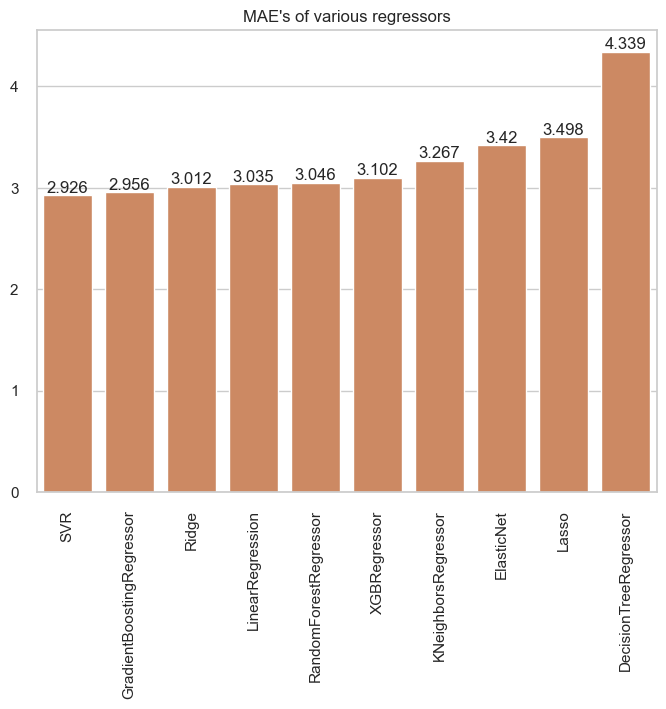

In [64]:
scores = pd.DataFrame(scores).sort_values("mae", ascending = True)
plot_bars(scores, "mae", "", "MAE's of various regressors")

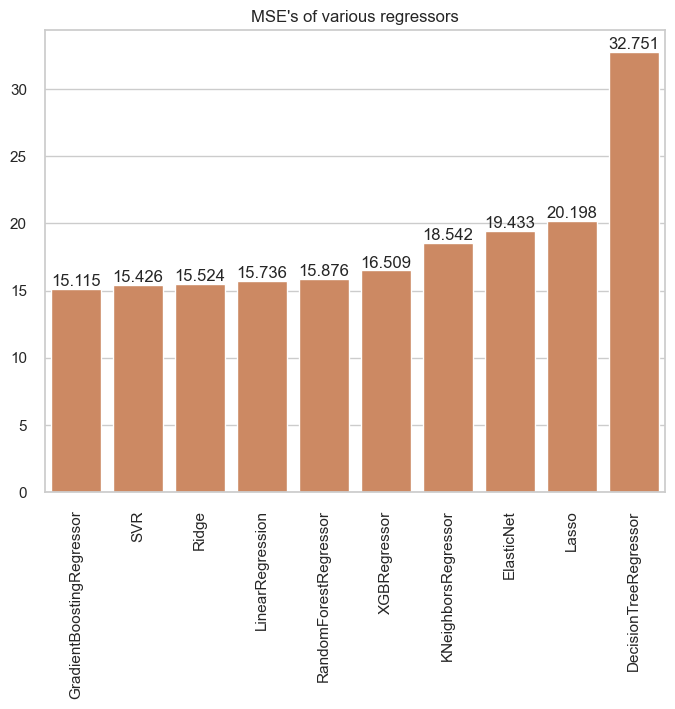

In [65]:
scores = pd.DataFrame(scores).sort_values("mse", ascending = True)
plot_bars(scores, "mse", "", "MSE's of various regressors")

The plot above shows that the best regressors are support vector regressor and the gradient boosting regressor as the generate the lowest scores (SVR mean absolute error - 2.926; Gradient Boosting Regressot mean absolute error - 2.956).

#### Feature importances

For the purpose of feature engeneering feature importances of ensemble regressors were calculated and plotted. 

In [31]:
X_pipe = pd.DataFrame(preprocessor.fit_transform(X))
X_pipe_train = pd.DataFrame(preprocessor.fit_transform(X_train))
X_pipe_val = pd.DataFrame(preprocessor.fit_transform(X_val))
X_pipe_test = pd.DataFrame(preprocessor.fit_transform(X_test))

In [32]:
preprocessor.get_feature_names_out()

array(['numeric__loan_amount', 'numeric__emp_length',
       'numeric__annual_inc', 'numeric__delinq_2yrs',
       'numeric__risk_score', 'numeric__inq_last_6mths',
       'numeric__pub_rec', 'numeric__revol_util', 'numeric__total_acc',
       'numeric__dti', 'numeric__acc_now_delinq',
       'numeric__chargeoff_within_12_mths', 'numeric__delinq_amnt',
       'numeric__pub_rec_bankruptcies',
       'categorical__loan_status_Charged Off',
       'categorical__loan_status_Current',
       'categorical__loan_status_Fully Paid',
       'categorical__loan_status_In Grace Period',
       'categorical__initial_list_status_f',
       'categorical__initial_list_status_w',
       'categorical__verification_status_Not Verified',
       'categorical__verification_status_Source Verified',
       'categorical__verification_status_Verified',
       'categorical__home_ownership_MORTGAGE',
       'categorical__home_ownership_OWN',
       'categorical__home_ownership_RENT', 'categorical__purpose_car',
 

In [34]:
X_pipe_train.columns = X_pipe_val.columns = X_pipe_test.columns = X_pipe.columns = [
      'numeric__loan_amount', 'numeric__emp_length',
       'numeric__annual_inc', 'numeric__delinq_2yrs',
       'numeric__risk_score', 'numeric__inq_last_6mths',
       'numeric__pub_rec', 'numeric__revol_util', 'numeric__total_acc',
       'numeric__dti', 'numeric__acc_now_delinq',
       'numeric__chargeoff_within_12_mths', 'numeric__delinq_amnt',
       'numeric__pub_rec_bankruptcies',
       'categorical__loan_status_Charged Off',
       'categorical__loan_status_Current',
       'categorical__loan_status_Fully Paid',
       'categorical__loan_status_In Grace Period',
       'categorical__initial_list_status_f',
       'categorical__initial_list_status_w',
       'categorical__verification_status_Not Verified',
       'categorical__verification_status_Source Verified',
       'categorical__verification_status_Verified',
       'categorical__home_ownership_MORTGAGE',
       'categorical__home_ownership_OWN',
       'categorical__home_ownership_RENT', 'categorical__purpose_car',
       'categorical__purpose_credit_card',
       'categorical__purpose_debt_consolidation',
       'categorical__purpose_home_improvement',
       'categorical__purpose_major_purchase',
       'categorical__purpose_medical', 'categorical__purpose_moving',
       'categorical__purpose_other',
       'categorical__purpose_small_business',
       'categorical__purpose_vacation']

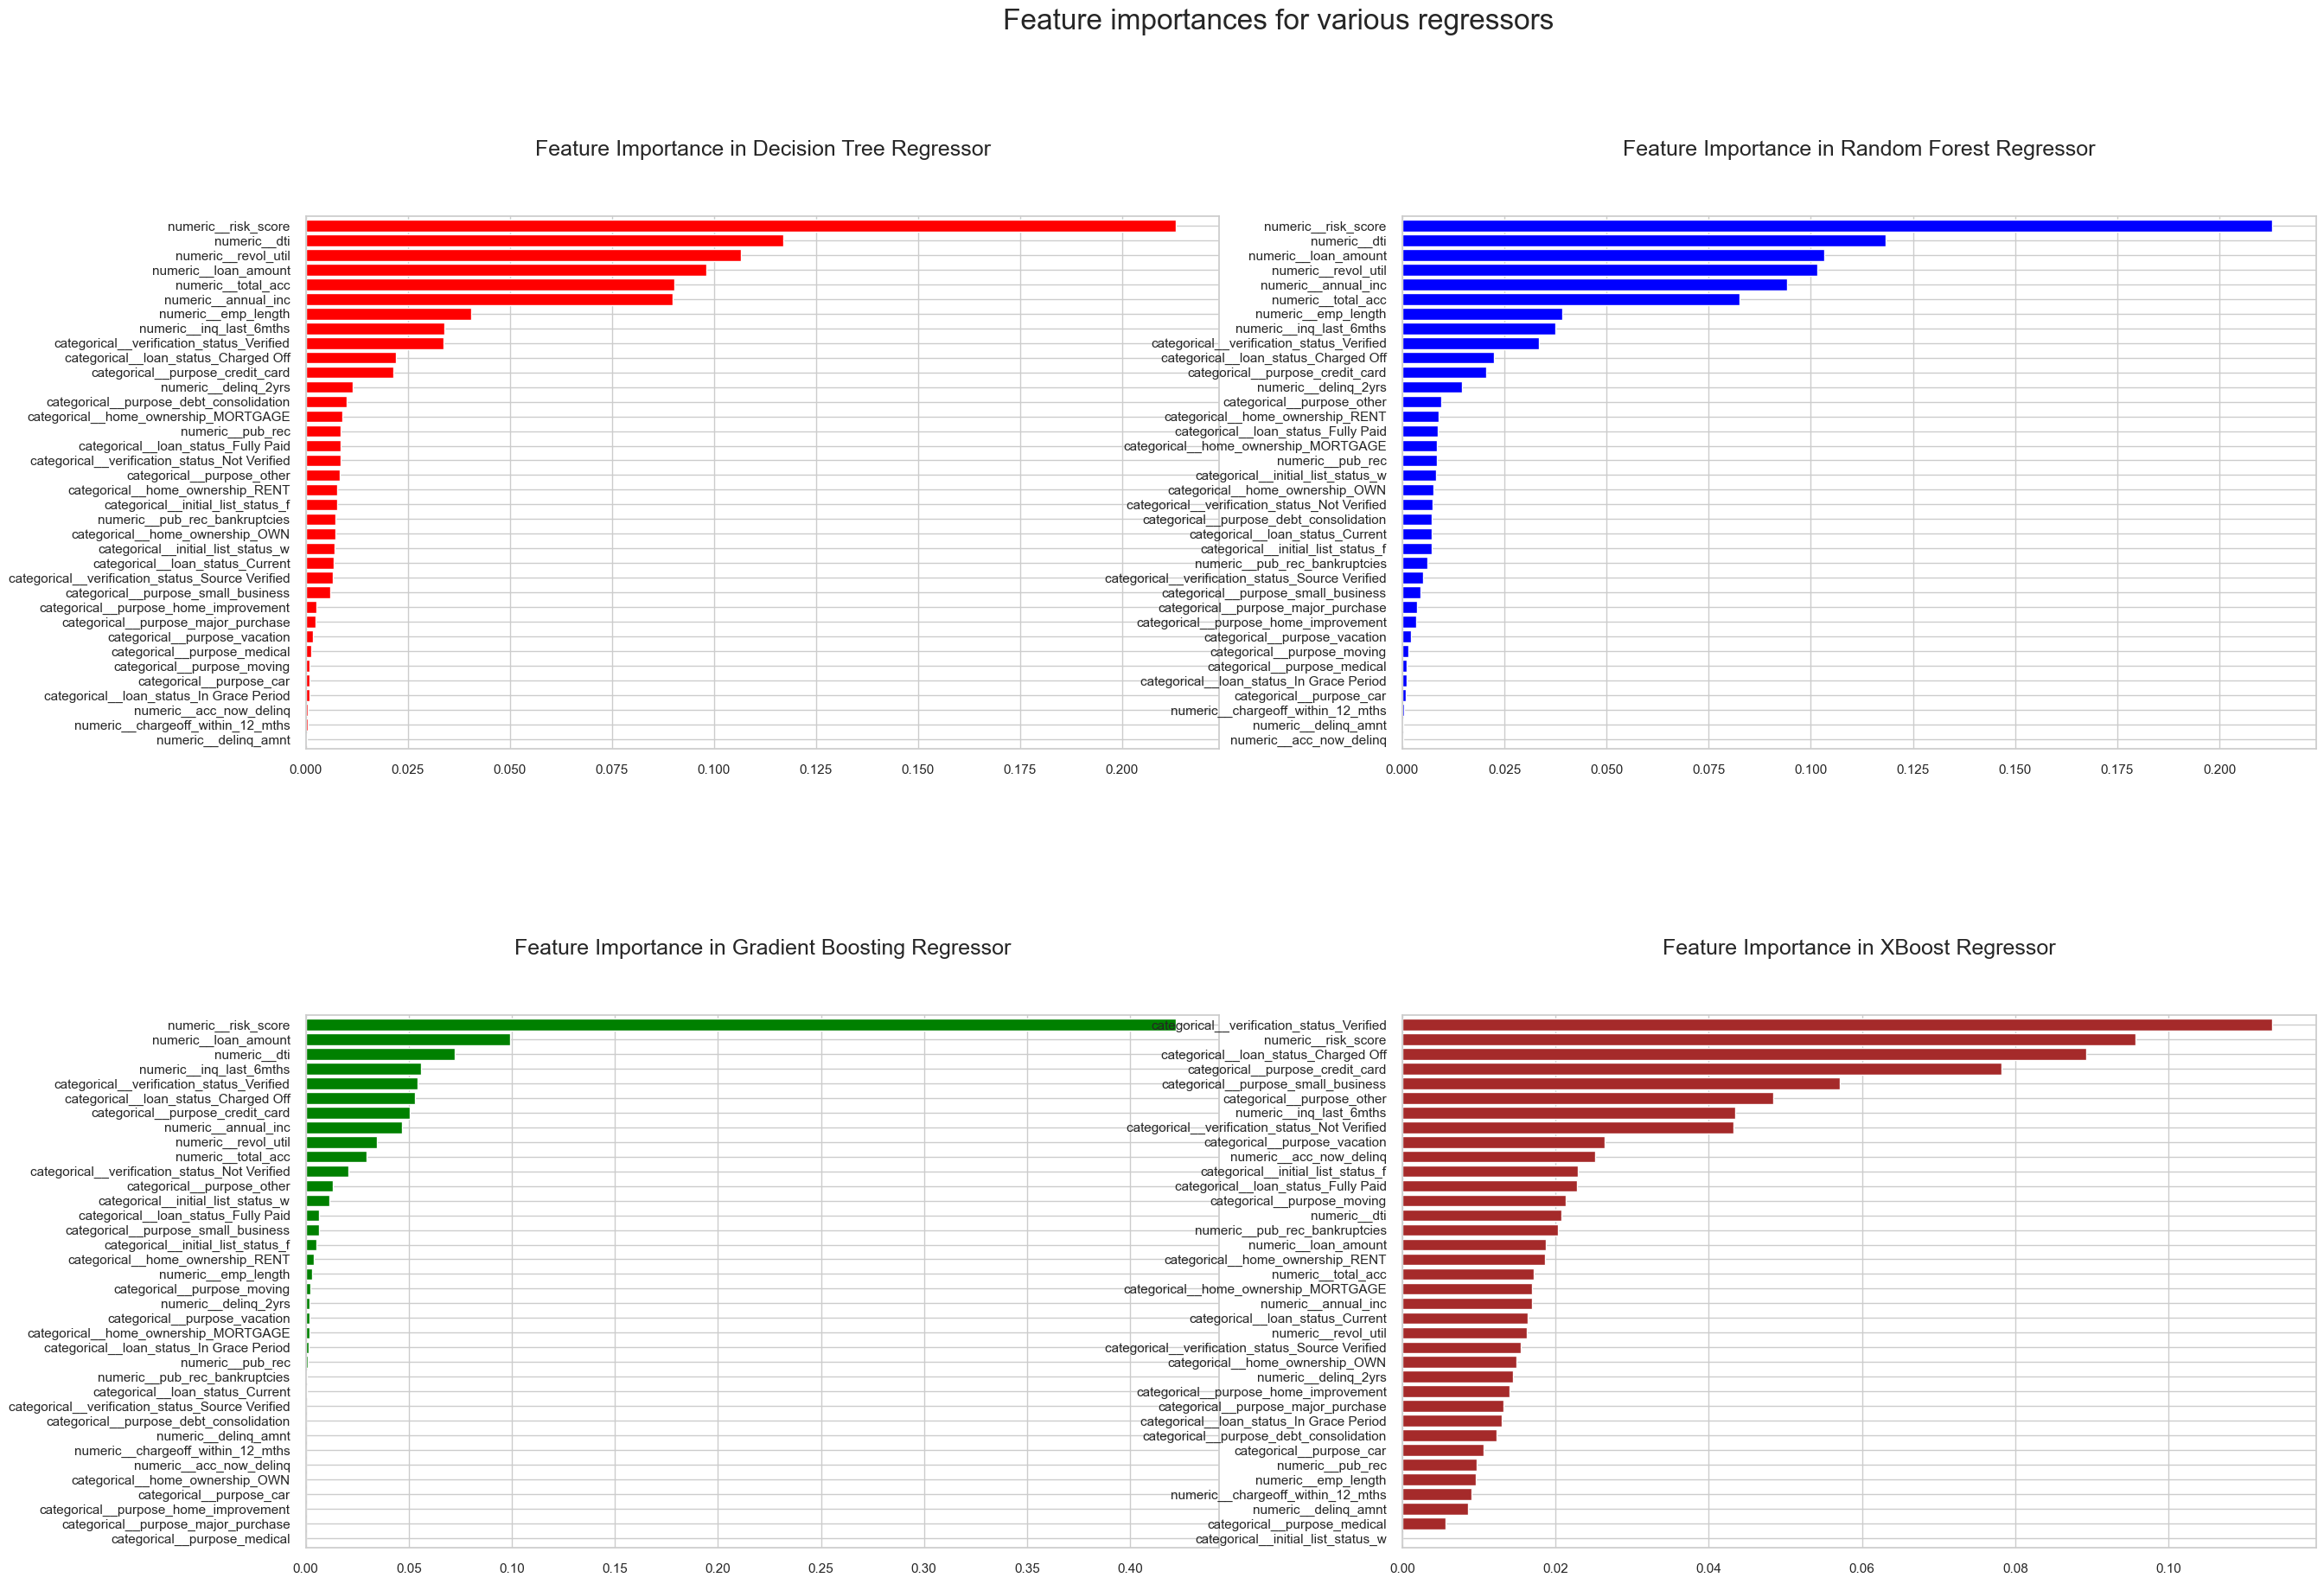

In [36]:
indices = [1, 2, 3, 9]
models_new = [models[index] for index in indices]
model_list = [ 'Decision Tree Regressor','Random Forest Regressor',
              'Gradient Boosting Regressor','XBoost Regressor']
color_list = ['red','blue','green','brown']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Feature importances for various regressors", fontsize=24, y=1)

for model, ax in zip(models_new, axs.ravel()):
    pd.Series(model[1].feature_importances_, index = X_pipe_val.columns).\
    sort_values(ascending=True).plot.barh(width=0.8,ax = ax,color=color_list[models_new.index(model)])
    ax.set_title(f'Feature Importance in {model_list[models_new.index(model)]}', fontsize=18, y=1.1)
    ax.set_xlabel("")

plt.show()

#### Feature selection based on feature importances

Features for further analysis were selected in two ways: 1) by examining feature importances and selecting the most important features; 2) by selecting features manually.

##### 1) Feature selection after encoding

The list of feature names sorted by feature importances from was obtained. 

In [38]:
pd.DataFrame(models[3][1].feature_importances_, index = X_pipe_val.columns).sort_values(0, ascending = False)

,0
numeric__risk_score,0.422291
numeric__loan_amount,0.099131
numeric__dti,0.072202
numeric__inq_last_6mths,0.055814
categorical__verification_status_Verified,0.054239
categorical__loan_status_Charged Off,0.052938
categorical__purpose_credit_card,0.050633
numeric__annual_inc,0.046876
numeric__revol_util,0.034702
numeric__total_acc,0.029305


In [40]:
features_selected_df = pd.DataFrame(models[3][1].\
                                    feature_importances_, index = X_pipe_val.columns).\
                                    sort_values(0, ascending = False).loc[:"categorical__loan_status_Current",:]

In [41]:
columns_list = []
for col in X_pipe_train.columns.tolist():
    if col in features_selected_df.transpose().columns.tolist():
        columns_list.append(X_pipe_train.columns.tolist().index(col))
    else:
        pass
    

In [95]:
X_pipe_select = X_pipe.iloc[:,columns_list]
X_pipe_train_select = X_pipe_train.iloc[:,columns_list]
X_pipe_val_select =  X_pipe_val.iloc[:,columns_list]
X_pipe_test_select = X_pipe_test.iloc[:,columns_list]

The models were run on the new list of features. 

In [51]:
cross_vals = []
models_selected = []
predictions_selected = []
scores_selected = {}
scores_selected["mae"] = []
scores_selected["mse"] = []
scores_selected["model_name"] = []
scores_selected["rmse"] = []
scores_selected["r2_score"] = []
for regressor in regressors:
    model = regressor.fit(X_pipe_train_select, y_train)
    prediction = model.predict(X_pipe_val_select)
    cross_test = cross_validate(model, X_pipe_train_select, y_train, cv=5,
                                scoring=("neg_mean_absolute_error", "neg_mean_squared_error","r2"))
    cross_vals.append(cross_test)
    models_selected.append(model)
    predictions_selected.append(prediction)
    print (regressor.__class__.__name__)
    print (f'Cross-validation')
    print ("MAEs: {}".format(list(cross_test.values())[2]))
    print ("MSEs: {}".format(list(cross_test.values())[3]))
    print ("R2_scores: {}".format(list(cross_test.values())[4]))
    mae = sum(list(cross_test.values())[2])/len(list(cross_test.values())[2])
    mse = sum(list(cross_test.values())[3])/len(list(cross_test.values())[3])
    r2s = sum(list(cross_test.values())[4])/len(list(cross_test.values())[4])
    rmse = np.sqrt(abs(mse))
    print("MAE (average): {}".format(abs(mae)))
    print("MSE (average): {}".format(abs(mse)))
    print("RMSE (average): {}".format(rmse))
    print("R2_score (average): {}".format(abs(r2s)))
    print('')
    scores_selected["model_name"].append(f'{regressor.__class__.__name__}')
    scores_selected["mae"].append(abs(mae).round(3))
    scores_selected["mse"].append(abs(mse).round(3))
    scores_selected["rmse"].append(rmse.round(3))
    scores_selected["r2_score"].append(abs(r2s).round(3))

LinearRegression
Cross-validation
MAEs: [-3.09123943 -3.09033841 -2.94817384 -2.95074063 -2.96927749]
MSEs: [-16.59754895 -16.6634962  -14.43194976 -14.98217581 -14.91842166]
R2_scores: [0.32489669 0.32370387 0.33511471 0.33210169 0.34283913]
MAE (average): 3.009953961523604
MSE (average): 15.518718476404436
RMSE (average): 3.9393804686021934
R2_score (average): 0.3317312198317233

DecisionTreeRegressor
Cross-validation
MAEs: [-4.58454762 -4.4256381  -4.31127619 -4.18058571 -4.31698095]
MSEs: [-36.42105138 -33.77254562 -31.20457276 -30.50055157 -32.40863676]
R2_scores: [-0.48142189 -0.37067525 -0.43760626 -0.35970016 -0.42760999]
MAE (average): 4.363805714285714
MSE (average): 32.86147161904762
RMSE (average): 5.732492618316017
R2_score (average): 0.4154027101854096

RandomForestRegressor
Cross-validation
MAEs: [-3.1322451  -3.12335114 -2.98151667 -2.97623467 -2.96647524]
MSEs: [-17.04747574 -16.94896551 -14.96133752 -15.1684839  -15.05489398]
R2_scores: [0.30659597 0.31211796 0.310725

In [52]:
scores_selected = pd.DataFrame(scores_selected)
scores_selected = scores_selected.set_index('model_name')
scores_selected

,mae,mse,rmse,r2_score
model_name,,,,
LinearRegression,3.010,15.519,3.939,0.332
DecisionTreeRegressor,4.364,32.861,5.732,0.415
RandomForestRegressor,3.036,15.836,3.979,0.318
GradientBoostingRegressor,2.953,15.099,3.886,0.350
SVR,2.928,15.463,3.932,0.334
KNeighborsRegressor,3.275,18.761,4.331,0.192
Lasso,3.498,20.199,4.494,0.130
Ridge,3.010,15.517,3.939,0.332
ElasticNet,3.420,19.433,4.408,0.163


In [53]:
for model in models_selected:
    joblib.dump(model, f'model_intrate{models_selected.index(model)}.joblib')

In [54]:
#scores = pd.DataFrame(scores).set_index("model_name")
scores_selected.to_csv('scores_lending_selected_intrate.csv')

In [55]:
scores_selected = pd.DataFrame(scores_selected).sort_values("mae", ascending = True)
plot_bars(scores_selected, "mae", "", "MAE's of various regressors")

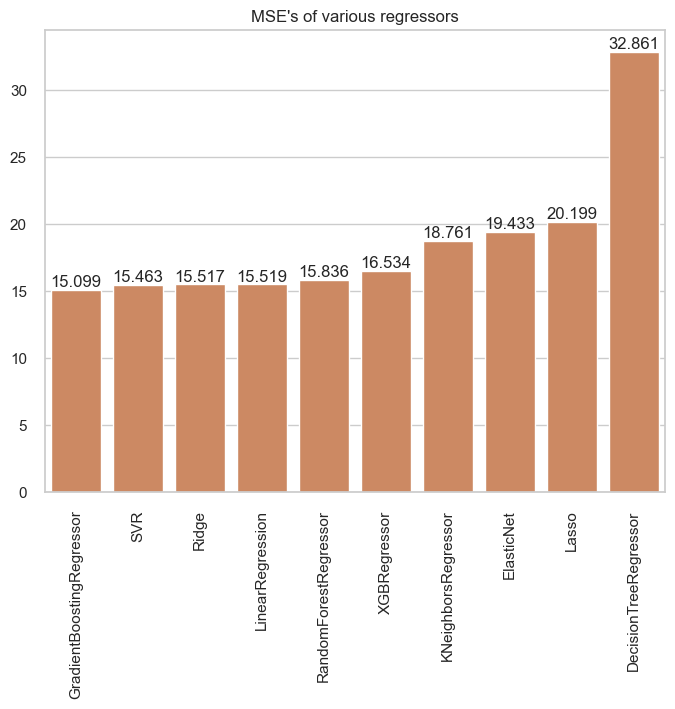

In [66]:
scores_selected = pd.DataFrame(scores_selected).sort_values("mse", ascending = True)
plot_bars(scores_selected, "mse", "", "MSE's of various regressors")

It can be seen from the plot that the scores of regressors are similar as for the initial set of features. The MAE and MSE for the Gradient Boosting Regressor is even slightly lower (2.953 and 15.099; thus, the model performs better for the reduced set of regressors). 

##### 1) Manual feature selection for pipeline

For this approach, numerical features which generated high scores for machine learning models predicting request status (see the II part) were selected and a categorical variable which had statistical significant impact on 'grade' variable (chi square test result) was selected.

In [67]:
num_feature_list = ['emp_length', 'risk_score','loan_amount', 'dti']
cat_feature_list = ['loan_status']


The function for feature selecting and including into preprocessor was created.

In [68]:
def feature_selector_for_preprocessor(num_feature_list, cat_feature_list):
    numeric_features_selected = num_feature_list
    categorical_features_selected = cat_feature_list
    preprocessor = ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_features_selected),
        ('categorical', categorical_transformer, categorical_features_selected),
    ])
    return preprocessor

In [69]:
preprocessor = feature_selector_for_preprocessor(num_feature_list, cat_feature_list)

In [74]:
cross_vals = []
models_selected1 = []
predictions = []
scores_selected1 = {}
scores_selected1["mae"] = []
scores_selected1["mse"] = []
scores_selected1["model_name"] = []
scores_selected1["rmse"] = []
scores_selected1["r2_score"] = []
for regressor in regressors:
    score_regression_model(X_train, y_train, X_val, y_val, regressor, scores_selected1, models_selected1)

LinearRegression
Cross-validation
MAEs: [-3.34203542 -3.30693318 -3.13758973 -3.15381563 -3.18831967]
MSEs: [-18.89449501 -18.90591075 -16.37640084 -16.90212477 -17.06299265]
R2_scores: [0.23146869 0.23269438 0.24553313 0.24651127 0.24837015]
MAE (average): 3.2257387249773948
MSE (average): 17.628384803530473
RMSE (average): 4.198617010818023
R2_score (average): 0.24091552432307659

DecisionTreeRegressor
Cross-validation
MAEs: [-4.58415238 -4.65966667 -4.42284762 -4.4226619  -4.6324381 ]
MSEs: [-36.700456   -37.53305895 -33.38150419 -32.71301071 -36.60467305]
R2_scores: [-0.49278664 -0.52329752 -0.5378983  -0.45833054 -0.61244663]
MAE (average): 4.544353333333333
MSE (average): 35.38654058095237
RMSE (average): 5.948658721170039
R2_score (average): 0.5249519250446408

RandomForestRegressor
Cross-validation
MAEs: [-3.45541852 -3.47869357 -3.26301286 -3.30809838 -3.26146686]
MSEs: [-20.2459486  -20.66560301 -17.68219726 -18.60281969 -18.10283567]
R2_scores: [0.17649847 0.16127641 0.18537

In [75]:
scores_selected1 = pd.DataFrame(scores_selected1)
scores_selected1 = scores_selected1.set_index('model_name')
scores_selected1

,mae,mse,rmse,r2_score
model_name,,,,
LinearRegression,3.226,17.628,4.199,0.241
DecisionTreeRegressor,4.544,35.387,5.949,0.525
RandomForestRegressor,3.353,19.060,4.366,0.179
GradientBoostingRegressor,3.182,17.252,4.154,0.257
SVR,3.149,17.699,4.207,0.238
KNeighborsRegressor,3.482,20.345,4.511,0.123
Lasso,3.498,20.198,4.494,0.130
Ridge,3.226,17.632,4.199,0.241
ElasticNet,3.462,19.835,4.454,0.146


In [76]:
for model in models_selected1:
    joblib.dump(model, f'model_intrate{models_selected1.index(model)}.joblib')

In [77]:
#scores = pd.DataFrame(scores).set_index("model_name")
scores_selected1.to_csv('scores_lending_selected_intrate.csv')

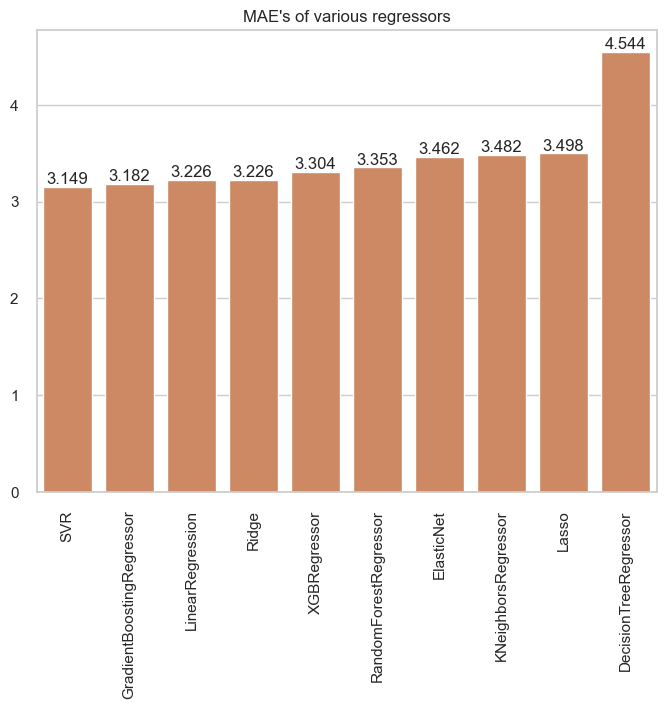

In [78]:
scores_selected1 = pd.DataFrame(scores_selected1).sort_values("mae", ascending = True)
plot_bars(scores_selected1, "mae", "", "MAE's of various regressors")

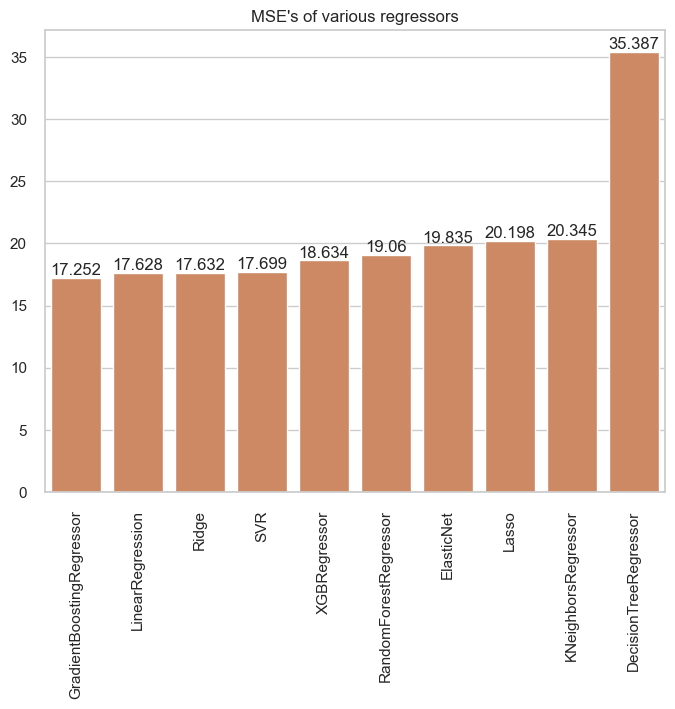

In [79]:
scores_selected1 = pd.DataFrame(scores_selected1).sort_values("mse", ascending = True)
plot_bars(scores_selected1, "mse", "", "MSE's of various regressors")

It can be seen that the scores after manual selection of features are higher ( the best MSE for the Gradient Boosting Regressor - 17.252), thus, those models perform worse compating to the feature seletion based on feature importances.

#### Hyperparameter tuning - Bayesian optimization

Hyperparameter tuning with the Bayesian optimization was performed for the dataset with features selected based on feature importances. For that purpose it was needed to get the preprocessed dataset and to set parameters.

Parameters for the hyper parameter tuning were obtained from the full list of parameters for the chosen regressors.

In [86]:
for regressor in regressors:
    print(regressor)
    print(regressor.get_params())
    print('')

LinearRegression()
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

DecisionTreeRegressor()
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

RandomForestRegressor()
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

GradientBoostingRegressor()
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None,

In [87]:
regressor_params = {
    "LinearRegression": {},
     "DecisionTreeRegressor": {
        "regressor__criterion": ['squared_error', 'absolute_error'],
        "regressor__max_depth": [3, 5, 7],
      #  "regressor__min_samples_leaf": [1, 2, 4],
        "regressor__max_features": [0.5, 0.8, 1.0]
    },
    "RandomForestRegressor": {
     #   "regressor__n_estimators": [100, 200, 300],
        "regressor__criterion": ['squared_error', 'absolute_error'],
        "regressor__max_depth": [3, 5, 7],
      #  "regressor__min_samples_split": [2, 5, 10],
       # "regressor__min_samples_leaf": [1, 2, 4],
        "regressor__max_features": [0.5, 0.8, 1.0]
    },
    
    
    "GradientBoostingRegressor": {
    #    "regressor__n_estimators": [100, 200, 300],
        "regressor__learning_rate": [0.01, 0.05, 0.1],
        "regressor__max_depth": [3, 5, 7],
      #  "regressor__min_samples_split": [2, 5, 10],
     #   "regressor__min_samples_leaf": [1, 2, 4],
        "regressor__max_features": [0.5, 0.8, 1.0]
    },
    "SVR": {
        "regressor__kernel": ["linear", "poly", "rbf"],
        "regressor__C": [0.1, 1, 10],
        "regressor__epsilon": [0.01, 0.1, 0.2]
    },
    "KNeighborsRegressor": {
        "regressor__n_neighbors": [3, 5, 7],
        "regressor__weights": ["uniform", "distance"],
        "regressor__p": [1, 2]
    },
    "Lasso": {
        "regressor__alpha": [0.01, 0.1, 1, 10]
    },
    "Ridge": {
        "regressor__alpha": [0.01, 0.1, 1, 10]
    },
    "ElasticNet": {
        "regressor__alpha": [0.01, 0.1, 1, 10],
        "regressor__l1_ratio": [0.1, 0.5, 0.7, 0.9]
    },
    "XGBRegressor": {
   #     "regressor__n_estimators": [100, 200, 300],
        "regressor__learning_rate": [0.01, 0.05, 0.1],
        "regressor__max_depth": [3, 5, 7],
     #   "regressor__min_child_weight": [1, 3, 5],
        "regressor__gamma": [0.0, 0.1, 0.2],
        "regressor__subsample": [0.8, 0.9, 1.0],
        #"regressor__colsample_bytree": [0.8, 0.9, 1.0]
    }
}


In [88]:
def objective(trial):
    regressor_name = trial.suggest_categorical('regressor', list(regressor_params.keys()))

    if regressor_name == "LinearRegression":
        regressor = LinearRegression()
        regressor.fit(X_pipe_train_select, y_train)

    elif regressor_name == "DecisionTreeRegressor":
        regressor = DecisionTreeRegressor(
            criterion=trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
            max_depth=trial.suggest_int('max_depth', 3, 7, step = 2),
            max_features=trial.suggest_float('max_features', 0.4, 1, step = 0.2)
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    elif regressor_name == "RandomForestRegressor":
        regressor = RandomForestRegressor(
            criterion=trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
            max_depth=trial.suggest_int('max_depth', 3, 7, step = 2),
            max_features=trial.suggest_float('max_features', 0.4, 1, step = 0.2),
            random_state = 42
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    elif regressor_name == "GradientBoostingRegressor":
        regressor = GradientBoostingRegressor(
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log = True),
            max_depth=trial.suggest_int('max_depth', 3, 7, step = 2),
            max_features=trial.suggest_float('max_features', 0.4, 1, step = 0.2)
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    elif regressor_name == "SVR":
        regressor = SVR(
            kernel=trial.suggest_categorical('kernel', ["linear", "poly", "rbf"]),
            C=trial.suggest_float('C', 1, 9, step = 4),
            epsilon=trial.suggest_float('epsilon', 0.01, 0.21, step = 0.1)
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    elif regressor_name == "KNeighborsRegressor":
        regressor = KNeighborsRegressor(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 7, step = 2),
            weights=trial.suggest_categorical('weights', ["uniform", "distance"]),
            p=trial.suggest_int('p', 1, 2, step = 1)
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    elif regressor_name == "Lasso":
        regressor = Lasso(
            alpha=trial.suggest_float('alpha', 0.01, 1.0)
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    elif regressor_name == "Ridge":
        regressor = Ridge(
            alpha=trial.suggest_float('alpha', 0.01, 1.0)
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    elif regressor_name == "ElasticNet":
        regressor = ElasticNet(
            alpha=trial.suggest_float('alpha', 0.01, 1.0),
            l1_ratio=trial.suggest_float('l1_ratio', 0.1, 0.9, step = 0.2)
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    else:
        regressor = xgb.XGBRegressor(
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log = True),
            max_depth=trial.suggest_int('max_depth', 3, 7, step = 2),
            gamma=trial.suggest_float('gamma', 0.1, 0.3, step =0.1),
            subsample=trial.suggest_float('subsample', 0.8, 1, step = 0.1)
        )
        regressor.fit(X_pipe_train_select, y_train)
        
    y_pred = regressor.predict(X_pipe_val_select)
    score = mean_absolute_error(y_val, y_pred)

    return score



In [373]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 100)
trial = study.best_trial
print("Best MAE score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Best MAE score:  2.9606829089408437
Best Params: 
  regressor: GradientBoostingRegressor
  learning_rate: 0.15402187854667423
  max_depth: 3
  max_features: 0.6000000000000001


The Optuna study suggested the Gradient Boosting Regressor (learning_rate = 0.15, max_depth = 3, max_features = 0.6) as the best estimator.

#### Predicting values and evaluating tuned models on the test dataset

The estimator was assessed on the test data and similar scores were found. The estimator was chosen for the prediction purposes.

In [380]:
model = GradientBoostingRegressor(learning_rate = 0.15402187854667423, 
                                  max_depth= 3,
                                  max_features = 0.6000000000000001).fit(X_pipe_train_select, y_train)

y_pred = model.predict(X_pipe_test_select)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2s = r2_score(y_test, y_pred)
rmse = np.sqrt(abs(mse))
print("MSE: {}".format(abs(mse)))
print("MAE: {}".format(abs(mae)))
print("RMSE: {}".format(rmse))
print("R2 score: {}".format(abs(r2s)))

MSE: 14.730387868008176
MAE: 2.9262959629460243
RMSE: 3.8380187425295587
R2 score: 0.3686990304965324


In [379]:
joblib.dump(model, 'best_model.joblib')

['best_model.joblib']

In [ ]:
model = joblib.load('best_model.joblib')

#### Correlations between target variable and selected feature variables

In order to identify what is the direction of relationhip between target variable and selected features, correlation analysis was performed.

In [101]:
merged_df = pd.concat([X_pipe_select, pd.DataFrame(y).reset_index(drop=True)],axis = 1)

In [102]:
merged_df

,numeric__loan_amount,numeric__emp_length,numeric__annual_inc,numeric__delinq_2yrs,numeric__risk_score,numeric__inq_last_6mths,numeric__pub_rec,numeric__revol_util,numeric__total_acc,numeric__dti,numeric__pub_rec_bankruptcies,categorical__loan_status_Charged Off,categorical__loan_status_Current,categorical__loan_status_Fully Paid,categorical__loan_status_In Grace Period,categorical__initial_list_status_f,categorical__initial_list_status_w,categorical__verification_status_Not Verified,categorical__verification_status_Verified,categorical__home_ownership_MORTGAGE,categorical__home_ownership_RENT,categorical__purpose_credit_card,categorical__purpose_moving,categorical__purpose_other,categorical__purpose_small_business,categorical__purpose_vacation,int_rate
0,-0.882625,-0.854635,0.573840,-0.358831,-0.566236,-0.649225,-0.361522,-0.719368,-1.347420,-1.523012,-0.350536,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.44
1,-1.297758,1.024588,-0.347317,-0.358831,0.194584,-0.649225,-0.361522,-0.093048,-1.099739,-0.253874,-0.350536,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.61
2,-0.467492,1.024588,-0.212514,1.962949,-1.174891,0.505089,-0.361522,0.281118,-1.017178,-0.335368,-0.350536,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,23.87
3,0.100585,1.024588,1.135520,-0.358831,0.955403,1.659404,-0.361522,0.891170,1.707318,-0.903655,-0.350536,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.99
4,-0.216227,-1.660016,-0.055243,-0.358831,-0.414072,0.505089,-0.361522,0.146906,-1.512541,-0.007218,-0.350536,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,23.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-1.101116,1.024588,-0.493354,-0.358831,-0.261908,-0.649225,-0.361522,1.541892,0.138669,0.621919,-0.350536,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,16.91
29996,-0.150680,1.024588,-0.543918,-0.358831,2.324878,-0.649225,-0.361522,-1.455497,-1.099739,-0.565726,-0.350536,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.35
29997,-1.101116,0.219207,-0.486670,-0.358831,0.194584,2.813718,-0.361522,0.415329,-1.182299,0.387215,-0.350536,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,15.61
29998,0.116971,-1.660016,-0.212514,-0.358831,-0.414072,2.813718,-0.361522,0.069633,-1.595102,-0.430988,-0.350536,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,25.82


In [104]:
merged_df.corrwith(merged_df["int_rate"])

numeric__loan_amount                             0.097355
numeric__emp_length                             -0.000965
numeric__annual_inc                             -0.067474
numeric__delinq_2yrs                             0.062047
numeric__risk_score                             -0.422634
numeric__inq_last_6mths                          0.188244
numeric__pub_rec                                 0.056477
numeric__revol_util                              0.259240
numeric__total_acc                              -0.044415
numeric__dti                                     0.178529
numeric__pub_rec_bankruptcies                    0.051529
categorical__loan_status_Charged Off             0.208451
categorical__loan_status_Current                -0.048571
categorical__loan_status_Fully Paid             -0.089803
categorical__loan_status_In Grace Period         0.023071
categorical__initial_list_status_f               0.112500
categorical__initial_list_status_w              -0.112500
categorical__v

The observations are presented in the conclusions for this part.

### Conclusions for the V part

From these parts of the analysis it can be concluded:
   1. Grades of persons whose loan applications are accepted can be predicted with such features as:
   
   - employment length (persons with the longer employment length will get higher grade);
   
   - risk score (persons whose risk score is higher will get higher grade);
   
   - loan amount (applications for higher amounts of loans will get higher grade); and
   
   - debt to income ration (persons with higher debt to income ratios will get lower grade);
   
   - loan_status (persons who are current or fully paid will receive higher grade);
   
   2. the classifier which performs the best on the validation and test data is the Gradient Boosting regressor (learning_rate = 0.15, max_depth = 3, max_features = 0.6). This model could be used for prediction purposes.
   
   3. The correlation coeficients between a target variable and feature variables are not high (that explains relatively weak predictive power of the regressors). It can be observed that:
- there is an negative relationship between interest rate and risk score - if the risk score is higher the interest rate for a loan is lower;
- there is an negative relationship between interest rate and status "not_verified" - if a person is more often qualified as 'verified", the interest rate for a loan is higher;
- there is an positive relationship between interest rate and debt to income ratio - if the debt to income ratio is higher the interest rate for a loan is higher;
- there is an positive relationship between interest rate and status "charged off" - if a person is more often qualified as 'charged_off", the interest rate for a loan is higher;
- there is an positive relationship between interest rate and status "verified" - if a person is more often qualified as 'verified", the interest rate for a loan is higher;
- there is an positive relationship between interest rate and "inquiry last 6months" - if there was inquiry in the last 6 months, the interest rate for a loan is higher.
- there is an positive relationship between interest rate and "revol_util" - if Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit is higher, the interest rate for a loan is higher.
   

## Conclusions

The following conclusions can be made from the results of data analysis of the Lending club dataset:

1. Persons will more likely receive a loan, will get higher grades and subgrades
 - with the longer employment length;
 - whose risk score is higher;

- applications for higher amounts of loans will more likely will be approved;

- persons with higher debt to income ratios will less likely receive a loan);

2. the classifier which performs the best predicting if a person will receive a loan is the Bagging classifier (accuracy score is 0.968).

3. The classifier which predicts loan receiver's grade is the Extra Tree classifier (n-estimators = 500, max_depth = 5) as the best estimator (accuracy score is 0.316). The model much better predicts values that are more frequent (such as grades A, B, and C) rather then les frequent values.

4. The classifier which quite well predicts subgrades of loan receivers is the Gradient Boosting classifier provides both good accuracy, precision and recall scores and performs similarly both on test and validation data (accuracy score - 0.068, recall score - 0.059, precision score - 0.05). The score are two or three times better than random guessing (probability - 1/35 or 0.02). The model much better predicts values that are more frequent (such as subgrades of A, B, and C) rather then les frequent values.

5. The regressor which performs the best predicting interest rates of loan receivers is the Gradient Boosting regressor (learning_rate = 0.15, max_depth = 3, max_features = 0.6). 

Also these relationships between interest rate and various features were observed:
- there is an negative relationship between interest rate and risk score - if the risk score is higher the interest rate for a loan is lower;
- there is an negative relationship between interest rate and status "not_verified" - if a person is more often qualified as 'verified", the interest rate for a loan is higher;
- there is an positive relationship between interest rate and debt to income ratio - if the debt to income ratio is higher the interest rate for a loan is higher;
- there is an positive relationship between interest rate and status "charged off" - if a person is more often qualified as 'charged_off", the interest rate for a loan is higher;
- there is an positive relationship between interest rate and status "verified" - if a person is more often qualified as 'verified", the interest rate for a loan is higher;
- there is an positive relationship between interest rate and "inquiry last 6months" - if there was inquiry in the last 6 months, the interest rate for a loan is higher.
- there is an positive relationship between interest rate and "revol_util" - if Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit is higher, the interest rate for a loan is higher.
   
#### Limitations:

- Hyperparameter tuning was not performed for possible parameters and classifiers due to time and computer power limitations.
- Not all features which could have potential effects on various target variables were examined. In fact, when the analysis was almost finished it was found that it would be possible to examined correlations between all numerical variables as features in the 'accepted' dataframe as well as categorical variables transformed with onehot encoding and target variables (subgrade after label encoding and interest rate). High positive and negative correlations could be a justification for feature selection for training machine learning models.

#### Suggestions for improvement:

- To perform analysis which is mentioned as limitations. 

## References

1. https://www.kaggle.com/datasets/wordsforthewise/lending-club
2. https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv?select=LCDataDictionary.xlsx